# Variational Autoencoder

In [2]:
import numpy as np


## generate random data

In [3]:
#
matrixSize = 5
A = np.random.rand(matrixSize, matrixSize) * 2 
B = np.dot(A, A.transpose())
print(B)
print(B.shape)

[[9.27445106 7.91907753 8.9162582  8.09893113 5.59122576]
 [7.91907753 8.93926961 8.17288076 8.47859455 6.83240846]
 [8.9162582  8.17288076 8.95725447 7.74857419 5.30108998]
 [8.09893113 8.47859455 7.74857419 9.00942231 7.48507471]
 [5.59122576 6.83240846 5.30108998 7.48507471 7.11143268]]
(5, 5)


In [4]:
mean = np.array([20, 30, 50, 30, 40])
print(mean.shape)


cov = B.copy()
print(cov.shape)
dataset = np.random.multivariate_normal(mean, cov, 6000)
dataset = dataset.astype(np.float32)
print(dataset)
dim = dataset.shape[1]


(5,)
(5, 5)
[[21.225996 30.745502 52.297947 28.686834 37.35667 ]
 [17.688168 27.348385 46.733734 29.001663 39.140015]
 [19.858063 29.051624 48.87534  30.562866 40.174183]
 ...
 [18.708712 27.116646 48.516796 27.238049 37.201588]
 [13.423599 26.582632 44.95714  24.44204  35.510323]
 [21.834663 31.08611  51.898117 30.749235 40.21113 ]]


In [5]:
mean = [0, 0]
cov = [[1, 0], [0, 100]]  # diagonal covariance
np.random.multivariate_normal(mean, cov, 5000).shape

(5000, 2)

## Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms

In [7]:
class VAE(nn.Module):
    def __init__(self, zdim, input_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, 20)
        self.fc21 = nn.Linear(20, zdim)
        self.fc22 = nn.Linear(20, zdim)
        self.fc3 = nn.Linear(zdim, 20)
        self.fc4 = nn.Linear(20, input_dim)
        self.input_dim = input_dim
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [8]:
def bce_loss(y_pred, y_true, input_dim):
#     print(y_pred)
#     print(y_true.view(-1, input_dim))
    BCE = F.binary_cross_entropy(y_pred, y_true.view(-1, input_dim), reduction='sum')
    return BCE

def mse_loss(y_pred, y_true):
    loss = nn.MSELoss(reduction='sum', size_average=False)
    return loss(y_pred, y_true)

def kld_Loss(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

def loss_function(y_pred, y_true, input_dim):
    recon_x, mu, logvar = y_pred
    x = y_true

#     BCE = bce_loss(recon_x, x, input_dim)
#     if BCE < 0:
#         print("BCE < 0")
    KLD = kld_Loss(mu, logvar)
#     if KLD < 0:
#         print("KLD < 0")
    MSE = mse_loss(recon_x, x)
    return KLD + MSE


In [9]:
def train(model, num_epochs = 1, batch_size = 64, learning_rate = 0.0002):
    model.train() #train mode
    torch.manual_seed(42)
    
    train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    optimizer = optim.Adam(model.parameters(), learning_rate)
    
    for epoch in range(num_epochs):
      for data in train_loader:  # load batch
#           print(data)
          
          reconmulogvar = model(data)
          loss = loss_function(reconmulogvar, data, 5) # calculate loss
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
      
      print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))

In [10]:
batch_size = 256

model = VAE(5, 5)
train(model, num_epochs = 600, batch_size = batch_size, learning_rate = 0.008)

/Users/yukuai/opt/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch:1, Loss:794593.8750
Epoch:2, Loss:782179.6250
Epoch:3, Loss:724276.6250
Epoch:4, Loss:715544.3750
Epoch:5, Loss:693139.3750
Epoch:6, Loss:690578.5000
Epoch:7, Loss:679259.1875
Epoch:8, Loss:661493.9375
Epoch:9, Loss:624439.5625
Epoch:10, Loss:552141.2500
Epoch:11, Loss:503735.7812
Epoch:12, Loss:457133.9375
Epoch:13, Loss:451407.1875
Epoch:14, Loss:401016.7500
Epoch:15, Loss:381137.2500
Epoch:16, Loss:353456.6875
Epoch:17, Loss:333942.2500
Epoch:18, Loss:309572.9375
Epoch:19, Loss:282245.9375
Epoch:20, Loss:267976.3125
Epoch:21, Loss:253761.5469
Epoch:22, Loss:235541.4219
Epoch:23, Loss:224206.5625
Epoch:24, Loss:220812.5156
Epoch:25, Loss:195233.3594
Epoch:26, Loss:194131.0625
Epoch:27, Loss:182027.8906
Epoch:28, Loss:170590.0312
Epoch:29, Loss:167467.9062
Epoch:30, Loss:160995.5156
Epoch:31, Loss:153110.1250
Epoch:32, Loss:147817.2344
Epoch:33, Loss:144345.9375
Epoch:34, Loss:137197.6875
Epoch:35, Loss:131952.6719
Epoch:36, Loss:130607.9609
Epoch:37, Loss:126392.4297
Epoch:38, 

Epoch:312, Loss:6057.6694
Epoch:313, Loss:5782.7100
Epoch:314, Loss:5669.9126
Epoch:315, Loss:5792.1382
Epoch:316, Loss:5616.5967
Epoch:317, Loss:5588.9238
Epoch:318, Loss:5745.1621
Epoch:319, Loss:5369.3120
Epoch:320, Loss:5562.4033
Epoch:321, Loss:5406.5889
Epoch:322, Loss:5456.9292
Epoch:323, Loss:5635.0171
Epoch:324, Loss:5360.5601
Epoch:325, Loss:5256.8936
Epoch:326, Loss:5427.2827
Epoch:327, Loss:5253.1255
Epoch:328, Loss:5410.1323
Epoch:329, Loss:5286.5908
Epoch:330, Loss:5171.6289
Epoch:331, Loss:5273.6899
Epoch:332, Loss:5124.4717
Epoch:333, Loss:5028.6958
Epoch:334, Loss:5042.0747
Epoch:335, Loss:5341.3350
Epoch:336, Loss:5092.8545
Epoch:337, Loss:4958.4526
Epoch:338, Loss:4748.1992
Epoch:339, Loss:4714.0635
Epoch:340, Loss:4774.1357
Epoch:341, Loss:4799.4922
Epoch:342, Loss:4730.3965
Epoch:343, Loss:4756.9014
Epoch:344, Loss:4723.6729
Epoch:345, Loss:4812.9424
Epoch:346, Loss:4847.1470
Epoch:347, Loss:4641.2451
Epoch:348, Loss:4664.0386
Epoch:349, Loss:4591.9868
Epoch:350, L

In [25]:
result = []
for i in range(1000):
  rinpt = torch.randn(1, 5)
  with torch.no_grad():
    si = model.decode(rinpt).numpy()
  result.append(si)

In [84]:

def get_most_similar_besides_i(simulated_data, test):
    min_idx = 100000
    min_distance = 1000000
    point2 = test
    for idx in range(len(simulated_data)):
        si = simulated_data[idx][0]
        distance = np.linalg.norm(si[:4] - point2[:4])
    #     print(distance)
        if distance < min_distance:
#             print(distance)
            min_idx = idx
            min_distance = distance
    return min_idx

In [46]:
result[504][0]

array([21.491606, 30.075415, 52.84059 , 29.09542 , 38.247578],
      dtype=float32)

In [48]:
dataset[0,:]

array([21.225996, 30.745502, 52.297947, 28.686834, 37.35667 ],
      dtype=float32)

In [66]:
testing_dataset = np.random.multivariate_normal(mean, cov, 3000)
testing_dataset = testing_dataset.astype(np.float32)

In [69]:
testing_dataset

array([[20.21027 , 30.200932, 50.463272, 29.811468, 40.06993 ],
       [18.540207, 28.919832, 49.37    , 27.604872, 37.95446 ],
       [25.181465, 34.200974, 55.128727, 34.07347 , 42.253334],
       ...,
       [26.715672, 34.902905, 56.487778, 35.071358, 43.694454],
       [13.339076, 25.535673, 44.382484, 24.197912, 36.02328 ],
       [21.168089, 31.404505, 52.194016, 29.431892, 38.38128 ]],
      dtype=float32)

In [79]:
get_most_similar_besides_i(result, testing_dataset[1])

24.408173
19.6353
16.786648
12.756523
11.425504
10.811397
5.1203628
4.7495193
2.5770907
2.3306131
2.2663717


871

In [85]:
for i in range(testing_dataset.shape[0]):
    idx = get_most_similar_besides_i(result, testing_dataset[i])
    print(testing_dataset[i], end="\t")
    print(result[idx])

[20.21027  30.200932 50.463272 29.811468 40.06993 ]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[18.540207 28.919832 49.37     27.604872 37.95446 ]	[[19.461174 28.653128 47.77372  28.896778 38.57797 ]]
[25.181465 34.200974 55.128727 34.07347  42.253334]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[21.109928 29.37139  50.658173 29.865969 39.107845]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[26.131842 37.7522   55.602993 38.907486 48.948803]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[19.364626 32.729248 50.285618 31.591284 41.760155]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[14.551156 24.870007 44.574165 24.946953 35.835983]	[[15.968832 25.86358  43.533264 24.946339 34.49881 ]]
[16.474546 27.158552 46.407307 27.685802 39.267284]	[[17.229359 26.164843 46.23752  26.6566   36.96799 ]]
[17.866968 27.830183 48.506943 26.75988  36.79409 ]	[[18.635122 28.588757 47.08152  27.524216 36.69205 ]]
[18.8203   29.927353 48.72705  30.358376 41.58

[15.306429 27.09002  46.199776 26.135603 37.65512 ]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[17.434013 27.540268 46.5974   29.018347 40.07616 ]	[[18.606276 28.003616 47.24221  28.731857 39.139236]]
[24.209063 32.5288   53.305653 33.737804 42.029926]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[16.298462 27.729324 46.489353 27.901714 38.694946]	[[16.354265 28.818737 47.174416 28.788815 40.632664]]
[22.187788 32.622623 52.243958 32.56998  42.180122]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[16.499676 25.829153 46.993366 24.674665 34.757706]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[16.758732 26.82927  46.661198 26.961905 38.028366]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[17.416376 27.69982  47.400547 27.762197 39.155193]	[[18.635122 28.588757 47.08152  27.524216 36.69205 ]]
[21.963179 29.999275 50.374878 32.524326 42.97723 ]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[18.63538  27.23107  47.9257   28.378368 38.71

[18.369106 29.56016  48.72401  29.21651  39.751007]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[18.240316 25.476885 47.943523 25.552858 35.574917]	[[17.192654 25.658487 47.931023 26.34977  37.12943 ]]
[25.976366 34.545246 55.923244 34.26224  42.689472]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[19.300407 31.254217 50.091885 30.338737 40.81841 ]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[20.204082 33.59314  50.404324 33.940277 45.05221 ]	[[19.394852 33.036114 52.890488 34.141487 47.314213]]
[23.3073   34.096046 54.267933 32.3083   40.37941 ]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[20.791727 30.086498 50.763973 30.042503 40.23563 ]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[15.667796 26.89058  46.442036 25.744429 37.756546]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[12.985041 23.676023 43.32504  23.396784 34.683453]	[[13.457306 24.886106 41.46203  24.105804 35.040783]]
[16.912613 25.113787 46.253605 26.034208 36.38

[20.999638 29.692728 50.618484 30.090818 39.904488]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[21.299627 34.40817  51.917477 33.91474  44.29901 ]	[[19.394852 33.036114 52.890488 34.141487 47.314213]]
[16.323324 27.165499 46.2658   27.46861  38.604996]	[[17.229359 26.164843 46.23752  26.6566   36.96799 ]]
[12.100599 23.955994 42.37397  24.151617 36.941837]	[[13.457306 24.886106 41.46203  24.105804 35.040783]]
[15.1705265 24.91716   44.74745   25.81653   38.29676  ]	[[15.968832 25.86358  43.533264 24.946339 34.49881 ]]
[21.902143 31.092226 52.108524 30.490688 39.89315 ]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[18.955246 29.766054 48.496075 30.769312 42.382576]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[17.601639 28.758957 46.523064 30.878744 42.533596]	[[16.354265 28.818737 47.174416 28.788815 40.632664]]
[20.688591 29.599022 49.928436 30.789795 41.300606]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[20.047712 30.128824 50.67671  29.127346 

[13.3475   23.401049 43.337093 23.72876  35.379063]	[[13.457306 24.886106 41.46203  24.105804 35.040783]]
[17.712183 27.516605 47.553596 28.067932 39.09102 ]	[[18.606276 28.003616 47.24221  28.731857 39.139236]]
[19.149652 29.724245 49.734566 28.733704 38.390434]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[18.275024 27.554016 47.67937  28.333742 39.511124]	[[18.606276 28.003616 47.24221  28.731857 39.139236]]
[19.653788 30.158192 49.1653   31.07228  41.091553]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[19.947058 28.37856  49.502666 28.949959 38.46853 ]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[23.02471  33.638382 51.494156 36.594654 47.279522]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[17.209686 27.819393 47.154625 28.009918 39.168728]	[[16.354265 28.818737 47.174416 28.788815 40.632664]]
[17.550484 28.591354 47.38783  29.202423 39.908447]	[[16.354265 28.818737 47.174416 28.788815 40.632664]]
[21.550566 29.808346 51.249966 30.08907  39.53

[22.643734 31.213305 53.155254 30.072126 39.005962]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[21.615337 29.290081 51.218353 29.6937   39.23365 ]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[22.103815 33.941597 52.45948  33.662758 44.22006 ]	[[19.394852 33.036114 52.890488 34.141487 47.314213]]
[15.192821 27.074184 45.976013 25.981667 37.473778]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[20.229317 31.712328 50.504448 31.292353 41.26394 ]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[21.163815 31.808405 51.34378  31.533552 41.87892 ]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[22.628445 30.119778 52.316586 30.172764 38.836388]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[22.255539 30.696404 52.85432  29.235546 37.179996]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[22.395645 31.41764  51.18394  33.432808 42.66074 ]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[25.463772 35.425797 56.237247 33.799488 42.82

[21.750082 30.04502  50.943184 31.243193 41.0787  ]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[21.155838 32.521404 49.899742 34.957874 45.7162  ]	[[19.394852 33.036114 52.890488 34.141487 47.314213]]
[21.75676  33.03747  51.563366 33.338768 43.20409 ]	[[19.394852 33.036114 52.890488 34.141487 47.314213]]
[21.935575 33.31879  53.26463  30.888187 40.78752 ]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[17.650135 26.417648 47.049637 27.33011  37.53866 ]	[[17.229359 26.164843 46.23752  26.6566   36.96799 ]]
[20.902117 34.648216 50.952103 35.32202  46.3155  ]	[[19.394852 33.036114 52.890488 34.141487 47.314213]]
[17.619017 25.152462 46.46302  26.820097 37.44957 ]	[[17.229359 26.164843 46.23752  26.6566   36.96799 ]]
[23.076376 33.92759  53.966194 32.32396  41.627094]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[24.583845 36.72567  55.667564 35.15863  44.698772]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[20.563013 32.18084  50.882965 31.750679 42.23

[19.43822  31.17222  49.42496  31.680517 42.910545]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[21.178297 32.091026 51.188515 32.217033 42.62341 ]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[17.598032 29.459448 47.97155  29.460331 40.972347]	[[16.354265 28.818737 47.174416 28.788815 40.632664]]
[18.325823 29.772425 48.488308 29.88731  40.859142]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[17.928286 30.410048 48.948956 29.111973 40.1806  ]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[16.684622 27.784462 46.831753 27.854937 39.287086]	[[16.354265 28.818737 47.174416 28.788815 40.632664]]
[24.65129  35.418644 54.71086  35.52247  45.178654]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[18.690575 30.314867 49.042713 30.094511 40.520287]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[18.704151 30.891827 48.86551  31.22736  42.433403]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[16.3172   28.030935 46.878765 27.40501  37.43

[20.435183 32.78942  50.980846 32.252647 42.8645  ]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[27.785007 38.07883  57.41524  38.620983 47.152546]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[23.086344 30.52052  52.79484  30.180328 38.77139 ]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[18.95712  28.698471 49.029457 28.673851 39.08856 ]	[[19.461174 28.653128 47.77372  28.896778 38.57797 ]]
[22.108377 32.102776 51.74313  32.80639  42.078526]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[21.145529 33.366825 51.544426 32.96438  41.65143 ]	[[19.394852 33.036114 52.890488 34.141487 47.314213]]
[24.791683 32.497215 54.64499  32.385178 39.83796 ]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[22.432377 33.08189  52.57322  32.878155 42.146862]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[19.792185 29.058739 49.01168  30.42411  41.81834 ]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[17.674591 27.661823 47.993164 26.962484 37.06

[15.626002 27.635107 46.64183  26.389248 37.16548 ]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[16.210157 27.209406 46.931316 26.134592 36.87627 ]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[19.67391  28.313536 49.53841  28.299541 37.234398]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[24.682753 34.539185 54.951614 34.018238 43.084812]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[19.018713 27.924301 48.378967 28.771986 39.162174]	[[19.461174 28.653128 47.77372  28.896778 38.57797 ]]
[18.99633  28.649786 48.98738  28.462046 38.646507]	[[19.461174 28.653128 47.77372  28.896778 38.57797 ]]
[17.056032 27.567564 47.60635  26.75049  37.014114]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[20.79473  30.90087  50.902023 30.492931 41.031303]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[19.791334 30.235086 49.688625 30.493547 40.50562 ]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[18.887802 27.326946 48.102894 28.604506 38.85

[22.986166 32.907707 51.949593 34.859695 45.53603 ]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[19.108702 30.699337 47.371475 34.305244 47.339615]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[24.285822 34.105953 53.859898 34.797817 43.381   ]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[20.455301 35.906822 51.503757 35.178375 47.618008]	[[19.394852 33.036114 52.890488 34.141487 47.314213]]
[22.396336 31.63152  51.543835 32.81336  42.10718 ]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[21.385538 32.70531  51.499332 32.68363  42.7715  ]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[22.8762   30.387667 51.205315 32.605556 41.34422 ]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[24.206251 34.266655 54.145668 34.316887 43.811462]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[16.699802 28.874594 47.123436 28.879288 40.76402 ]	[[16.354265 28.818737 47.174416 28.788815 40.632664]]
[24.234283 31.802715 53.536583 32.47411  41.23

[22.90776  34.498184 52.61731  35.22264  45.71795 ]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[17.554981 26.039608 47.783203 25.412153 36.054928]	[[17.192654 25.658487 47.931023 26.34977  37.12943 ]]
[21.479307 30.291172 50.238888 32.241272 41.787045]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[13.714038 23.68355  43.830647 23.49863  34.934845]	[[15.672476 24.472134 43.1259   23.284336 32.367077]]
[19.587036 28.40791  48.88163  29.414938 39.05281 ]	[[19.461174 28.653128 47.77372  28.896778 38.57797 ]]
[19.11238  29.422398 48.408432 30.842892 42.5208  ]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[21.667233 29.502737 50.85356  30.686108 40.69354 ]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[27.009876 39.246243 57.25885  38.991043 47.157806]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[14.378041 25.561184 44.26069  26.233294 37.78302 ]	[[14.933014 26.015764 42.717346 24.916103 35.156124]]
[22.243021 32.29587  51.811035 33.255497 43.46

[19.637934 31.50151  50.187904 31.057745 41.451305]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[15.15779  26.285963 44.93838  26.98476  38.475243]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[23.248716 32.32915  53.032784 32.339848 41.496185]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[21.321503 31.283838 50.713806 32.424603 42.273144]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[17.096373 26.517988 47.419407 25.715143 35.18063 ]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[21.110247 31.44426  51.234882 31.227446 42.431557]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[14.660843 25.402552 45.58403  23.828377 34.94619 ]	[[15.968832 25.86358  43.533264 24.946339 34.49881 ]]
[18.257057 29.644352 47.73222  31.005754 41.9063  ]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[23.658298 34.81895  54.18012  34.052246 43.248814]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[22.97503  31.791292 51.9122   33.5775   42.77

[18.180155 26.26204  47.77245  26.694267 35.357567]	[[17.192654 25.658487 47.931023 26.34977  37.12943 ]]
[19.131927 29.517445 49.546707 28.923567 39.407906]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[19.804962 30.244741 50.017982 29.921902 40.102802]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[20.007156 28.513557 48.902103 30.135748 39.10481 ]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[20.622759 29.531204 50.72734  29.171947 38.49437 ]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[19.391014 29.689009 49.636013 29.17262  39.216003]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[25.380848 35.316612 55.8088   34.394676 42.749146]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[18.434826 28.390335 48.949047 27.507177 37.95512 ]	[[18.635122 28.588757 47.08152  27.524216 36.69205 ]]
[18.278212 28.285208 47.598854 29.55661  40.04993 ]	[[18.606276 28.003616 47.24221  28.731857 39.139236]]
[18.12249  29.517838 47.101067 31.602625 43.65

[22.061031 34.818264 53.43224  32.7256   43.22005 ]	[[19.394852 33.036114 52.890488 34.141487 47.314213]]
[23.23486  36.106194 53.699097 35.592007 46.116623]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[18.500433 28.612497 48.777782 28.088284 38.805775]	[[19.461174 28.653128 47.77372  28.896778 38.57797 ]]
[22.887598 34.228027 54.035862 32.565388 42.428444]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[26.233448 33.62604  55.86468  33.61986  41.038307]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[20.455727 30.242918 49.980297 31.10526  40.407894]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[22.339195 32.15963  52.311325 32.033848 42.213467]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[19.540152 27.166115 49.245354 27.181892 36.671318]	[[20.081356 26.174063 48.22843  25.496399 33.343235]]
[19.293903 29.340805 49.84241  28.44763  38.420017]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[27.720152 36.46964  58.04838  35.59802  43.75

[18.889017 30.172445 48.665546 30.705385 41.16261 ]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[18.126638 28.759169 47.997795 29.219894 40.063293]	[[18.606276 28.003616 47.24221  28.731857 39.139236]]
[22.307402 32.284527 52.63453  31.723064 41.47088 ]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[23.202532 33.947216 53.92937  32.906162 42.464653]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[15.467386 25.003128 45.681126 24.3983   34.349567]	[[15.968832 25.86358  43.533264 24.946339 34.49881 ]]
[19.255598 30.059736 49.222458 30.173521 40.52699 ]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[19.231812 29.692265 50.332157 27.478622 37.275455]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[13.880804 25.809319 44.69693  24.865883 37.28141 ]	[[14.933014 26.015764 42.717346 24.916103 35.156124]]
[21.151438 31.119797 50.507248 32.160824 41.74008 ]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[24.39209  32.728184 53.58566  33.73925  42.57

[15.648776 26.28674  46.180256 25.633295 36.567898]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[20.036768 31.77263  50.92847  30.576168 39.509018]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[19.62531  31.71852  50.354675 30.747261 40.900208]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[28.34869  38.587284 58.831226 37.702415 45.383217]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[21.263664 29.289381 50.67075  29.853197 39.152992]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[24.03916  33.111046 53.1276   34.675713 44.023556]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[21.530764 33.147453 51.74129  33.094585 44.23722 ]	[[19.394852 33.036114 52.890488 34.141487 47.314213]]
[15.523536 28.592783 46.08755  28.410694 40.13026 ]	[[15.973118 29.165508 46.86447  28.832893 40.184628]]
[20.034845 30.398415 50.23008  29.990644 40.271202]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[25.664944 35.952686 56.122826 35.08546  44.60

[20.248875 30.056347 50.48802  29.62525  40.312622]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[24.041054 34.77215  53.790123 35.378086 44.69595 ]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[14.93598  26.068735 45.81359  24.759785 35.30443 ]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[16.683094 29.24103  46.942997 29.349854 40.61178 ]	[[16.354265 28.818737 47.174416 28.788815 40.632664]]
[23.911348 32.93759  54.62431  31.295656 38.889194]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[19.460052 30.210245 49.78786  29.840683 39.830227]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[15.933305 25.410732 46.049244 25.285236 36.404232]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[18.729988 27.946688 48.640358 28.104565 38.719852]	[[18.606276 28.003616 47.24221  28.731857 39.139236]]
[24.570988 34.059082 54.156822 34.628273 43.101677]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[18.51695  31.096003 49.052944 30.563921 41.76

[13.812909 26.057058 43.50369  27.229504 39.783607]	[[14.933014 26.015764 42.717346 24.916103 35.156124]]
[18.613049 27.861252 48.78789  27.5622   37.569164]	[[18.635122 28.588757 47.08152  27.524216 36.69205 ]]
[21.900244 29.952263 51.399242 30.54339  39.142033]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[20.651201 33.072002 52.198982 30.760199 40.232563]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[18.721537 25.389845 47.79591  26.787254 36.78526 ]	[[17.192654 25.658487 47.931023 26.34977  37.12943 ]]
[22.032564 34.108444 52.451252 33.793617 43.56404 ]	[[19.394852 33.036114 52.890488 34.141487 47.314213]]
[20.792908 32.74602  52.065216 30.837337 39.894417]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[20.769499 31.670004 51.28331  30.900772 40.577774]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[17.454636 27.774864 47.189056 28.455153 39.278008]	[[18.606276 28.003616 47.24221  28.731857 39.139236]]
[23.325035 31.564472 53.50865  30.85975  39.57

[21.263004 31.215036 50.866566 31.716719 41.25626 ]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[23.787798 32.39387  53.401855 32.670883 41.770294]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[21.655878 31.93725  52.57117  30.356853 39.420925]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[22.504105 32.945854 52.917133 32.238575 41.802044]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[17.395226 28.667418 46.86661  30.027775 41.318165]	[[16.354265 28.818737 47.174416 28.788815 40.632664]]
[26.893274 36.14772  57.67941  34.441624 43.065777]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[20.607471 32.401062 50.90727  32.301933 43.445534]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[25.798656 34.230324 55.190693 35.261837 44.65123 ]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[14.840649 27.570547 46.009857 26.271696 38.83679 ]	[[13.921202 28.390596 44.824524 27.604    40.78139 ]]
[14.458437 25.490072 44.425175 25.672256 37.84

[23.819689 30.762812 52.867535 31.949863 41.022923]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[17.932653 25.63058  46.97311  27.069798 37.74744 ]	[[17.229359 26.164843 46.23752  26.6566   36.96799 ]]
[15.598221 26.103191 45.830154 25.979248 37.74423 ]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[22.105946 30.39866  51.81154  30.602272 40.442085]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[23.974907 33.562447 53.419556 34.24833  43.596024]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[20.49127  31.290634 51.449852 29.703371 39.02173 ]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[25.266659 35.35107  55.616276 34.637688 43.034454]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[18.405977 27.59654  49.119484 26.106396 35.575844]	[[20.081356 26.174063 48.22843  25.496399 33.343235]]
[22.480484 31.229311 51.88883  31.872684 41.495556]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[25.163498 32.25751  53.99783  33.815563 42.52

[16.762264 27.570082 46.9706   27.25752  37.492836]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[15.899447 27.349915 46.517673 26.459192 37.70277 ]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[17.625174 26.028824 47.476814 26.140135 36.275013]	[[17.192654 25.658487 47.931023 26.34977  37.12943 ]]
[22.465084 32.153637 53.094246 30.812399 40.067062]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[19.373127 29.365862 50.287323 27.529425 35.773922]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[22.073704 33.73498  52.18171  33.75924  43.434242]	[[19.394852 33.036114 52.890488 34.141487 47.314213]]
[19.050356 29.848658 49.430798 29.579912 40.198067]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[16.166739 25.999086 45.950115 26.290302 37.00241 ]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[19.501936 30.21991  49.040993 31.264893 41.331593]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[20.55947  29.971985 51.066593 28.908117 37.89

[18.2057   28.309351 48.411926 27.880457 38.083645]	[[18.635122 28.588757 47.08152  27.524216 36.69205 ]]
[12.742628 24.74478  42.971916 24.838705 37.653072]	[[13.457306 24.886106 41.46203  24.105804 35.040783]]
[25.059097 34.258904 55.239986 33.753876 41.914516]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[22.95639  30.233229 51.219402 33.047783 42.97899 ]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[20.312279 30.28081  50.146076 30.617117 41.08619 ]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[18.421467 28.535807 48.049103 29.533016 39.477383]	[[19.461174 28.653128 47.77372  28.896778 38.57797 ]]
[16.5733   24.958467 46.127903 25.445559 35.007114]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[20.966862 30.344545 50.600967 30.899649 41.22956 ]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[15.249954 26.245262 45.575523 26.244566 37.51029 ]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[19.2235   28.937183 48.941925 29.340094 39.67

[22.033634 35.306973 52.854877 34.24837  44.83487 ]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[15.798537 28.501585 45.89683  28.944738 41.037926]	[[15.973118 29.165508 46.86447  28.832893 40.184628]]
[20.816206 33.393818 52.182377 31.456457 42.12292 ]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[25.85184  33.806145 55.617096 33.641964 41.883923]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[21.226995 29.752876 50.77242  30.418104 39.668304]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[20.774012 30.442453 50.192097 31.410849 41.244823]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[17.215364 27.83725  47.444595 27.610518 38.60288 ]	[[18.635122 28.588757 47.08152  27.524216 36.69205 ]]
[24.534235 32.997887 53.833775 33.858864 41.68718 ]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[19.796774 28.049082 49.4657   28.416224 38.50081 ]	[[19.461174 28.653128 47.77372  28.896778 38.57797 ]]
[21.202442 30.283657 51.053715 30.23682  39.14

[21.254618 29.386084 50.09642  31.073702 40.911766]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[21.101912 31.104853 50.933052 31.248901 40.516144]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[24.108143 30.227928 53.660545 30.198792 37.64665 ]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[20.320133 30.596485 49.84942  31.484463 41.515606]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[13.690893 24.155401 43.902653 23.95971  35.24223 ]	[[15.672476 24.472134 43.1259   23.284336 32.367077]]
[22.674894 33.71564  52.729465 33.803963 43.36964 ]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[18.16612  29.90499  48.62178  29.530163 40.576878]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[15.355021 25.832184 45.672985 25.407673 35.834667]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[21.564472 29.439367 51.471115 29.065897 38.374268]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[19.630611 29.646734 48.911903 31.046871 41.89

[19.594807 29.398296 49.79899  28.861464 38.860188]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[18.545996 29.399796 49.68521  27.531103 36.22423 ]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[24.279997 33.343487 53.923237 33.65077  43.21914 ]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[21.737026 32.03298  52.081642 31.227669 40.525234]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[21.123283 31.442202 52.384197 29.159803 37.29533 ]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[19.021162 29.991375 49.00395  30.352512 40.941883]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[11.904419 23.82221  42.91182  22.520176 34.225025]	[[10.716667 22.327322 44.516823 22.326504 36.204426]]
[17.760374 29.82373  48.33377  28.981556 39.818035]	[[16.354265 28.818737 47.174416 28.788815 40.632664]]
[17.232779 27.134918 47.765232 26.344336 36.92508 ]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[15.82545  28.415321 46.630848 27.53767  38.95

[13.668547 25.669796 44.424244 24.662058 36.27812 ]	[[14.933014 26.015764 42.717346 24.916103 35.156124]]
[24.421896 33.147526 54.475292 32.616005 41.840202]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[21.20463  31.536802 50.95423  32.07367  43.49553 ]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[14.341524 24.16565  43.918503 25.09059  36.896564]	[[14.933014 26.015764 42.717346 24.916103 35.156124]]
[19.982336 31.090055 50.104725 31.158787 41.44337 ]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[20.51838  32.59584  50.994198 32.01636  42.425823]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[22.572107 33.546043 53.352375 31.98852  41.417805]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[22.051886 30.48876  50.85477  32.237206 41.520515]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[18.956198 30.219341 48.974506 30.375582 41.11711 ]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[21.258478 29.289103 50.682343 30.225828 39.17

[21.263357 30.72142  51.75635  29.442581 39.24841 ]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[22.926876 32.839558 53.35344  32.026455 40.969315]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[26.15914  35.612278 56.1072   35.258423 43.807102]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[23.245087 33.224167 54.35638  31.048641 39.328587]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[15.937878 29.124487 46.849327 27.928112 40.230873]	[[15.973118 29.165508 46.86447  28.832893 40.184628]]
[17.620686 30.47199  48.998104 28.471342 39.976486]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[19.256824 31.192629 49.41126  31.37666  42.45351 ]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[18.534437 26.69836  47.898373 27.568472 37.776188]	[[18.606276 28.003616 47.24221  28.731857 39.139236]]
[27.527458 34.74845  56.49528  35.980103 43.382595]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[24.38446  33.58809  54.65511  32.85014  41.21

[21.86056  29.527786 51.309246 29.896048 39.087055]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[17.389368 26.124716 47.240932 26.095543 36.50589 ]	[[17.192654 25.658487 47.931023 26.34977  37.12943 ]]
[20.35058  30.932262 50.751804 30.12348  40.04728 ]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[21.466223 28.990723 51.46625  28.520958 37.800453]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[23.01597  32.839226 53.514973 31.868204 41.636086]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[23.134142 33.413326 53.72602  32.39902  41.913357]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[17.68599  28.649483 48.136543 27.96108  38.107883]	[[18.635122 28.588757 47.08152  27.524216 36.69205 ]]
[22.882105 32.43949  53.060852 31.801441 40.432808]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[19.534805 29.262453 49.778408 28.652239 38.16875 ]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[17.111294 27.287052 47.174656 27.274353 37.70

[27.835564 36.902138 57.102097 37.783985 46.62422 ]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[22.050163 29.273027 51.702923 29.307726 38.22927 ]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[15.878349 25.126898 45.667324 25.443808 36.6261  ]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[20.184391 28.002796 49.62566  28.681192 38.819153]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[21.602428 29.833231 51.438404 29.884785 39.411762]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[25.147102 33.237297 54.668476 33.30885  41.07653 ]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[20.17699  32.183216 50.6156   31.777155 42.481632]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[13.498051 25.998882 43.480293 26.787298 39.208237]	[[14.933014 26.015764 42.717346 24.916103 35.156124]]
[20.427198 28.445436 49.886475 29.061613 39.332455]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[20.78978  31.316818 51.008633 31.237692 41.37

[24.441141 35.923985 54.242428 36.262066 45.622307]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[18.720568 31.24937  49.52264  30.21973  41.4101  ]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[20.366621 29.623045 49.65304  30.718515 41.509377]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[23.44253  33.932312 53.847332 33.254967 43.03296 ]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[14.560345 26.849804 45.243557 25.936134 37.642395]	[[13.921202 28.390596 44.824524 27.604    40.78139 ]]
[20.45914  31.544792 49.71973  33.071453 44.688442]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[15.203234 23.768587 45.241943 23.65034  33.78188 ]	[[15.672476 24.472134 43.1259   23.284336 32.367077]]
[17.021235 27.966398 47.13712  28.135698 38.680542]	[[16.354265 28.818737 47.174416 28.788815 40.632664]]
[17.931768 29.676641 48.5764   28.583792 40.20444 ]	[[19.461174 28.653128 47.77372  28.896778 38.57797 ]]
[19.172802 28.234173 49.050186 28.16196  37.83

[22.76614  31.120579 52.125095 31.942768 40.25477 ]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[25.308416 35.44976  55.581726 34.691708 43.651333]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[19.69739  27.829473 48.2421   30.096943 39.768673]	[[19.461174 28.653128 47.77372  28.896778 38.57797 ]]
[24.38935  32.265915 53.482044 33.576508 41.96939 ]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[21.92392  33.16119  51.82708  33.313522 42.600475]	[[19.394852 33.036114 52.890488 34.141487 47.314213]]
[23.21991  32.55933  53.04474  32.61811  41.967354]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[20.399427 34.5091   51.21376  33.867966 44.419685]	[[19.394852 33.036114 52.890488 34.141487 47.314213]]
[17.31789  30.59837  47.602848 30.566133 42.650845]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[19.114862 28.055323 49.307358 27.52022  37.54947 ]	[[19.461174 28.653128 47.77372  28.896778 38.57797 ]]
[21.73631  29.399857 51.93499  28.35752  36.85

[21.802845 30.995174 52.362095 29.784834 38.49389 ]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[18.093594 27.074493 47.420513 28.071209 38.841698]	[[18.606276 28.003616 47.24221  28.731857 39.139236]]
[23.283354 31.962162 52.910835 32.37186  42.061485]	[[22.753035 30.799562 54.20398  33.447678 44.40337 ]]
[18.650152 29.97234  48.92044  29.910309 40.82562 ]	[[19.726381 30.14307  48.374214 29.990166 39.85928 ]]
[21.21044  30.844074 51.413303 30.331636 39.884464]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[22.504597 30.327839 51.447742 31.734976 40.97382 ]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[22.086369 30.145298 51.895527 29.926954 39.343746]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]
[20.846605 31.693575 50.963642 31.275822 40.115295]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[23.731546 34.664394 53.824917 34.601856 44.264484]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[16.487062 24.286049 46.46905  24.033636 34.02

[16.502275 27.500183 46.635536 27.561895 38.31429 ]	[[16.629807 26.333355 46.769325 26.229328 36.78995 ]]
[20.72155  28.90624  50.124332 29.617594 38.67611 ]	[[20.424232 29.516518 50.462105 28.182346 37.043156]]
[28.2421   36.32539  57.55346  36.94131  44.931828]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[22.116316 31.67425  52.470993 31.10338  40.23925 ]	[[20.013796 30.948032 52.55803  31.55867  42.846355]]
[18.373066 27.612865 47.563034 29.135153 40.12535 ]	[[18.606276 28.003616 47.24221  28.731857 39.139236]]
[25.631758 33.62316  54.786533 34.78163  43.823517]	[[22.078447 35.039375 55.076828 36.05731  48.33296 ]]
[17.68341  28.70309  48.297638 28.091892 38.231777]	[[18.635122 28.588757 47.08152  27.524216 36.69205 ]]
[19.200037 30.713287 48.978043 31.307842 42.247253]	[[20.201462 31.03207  49.50746  31.782349 42.549583]]
[22.45013 33.88034 52.66857 33.64756 43.90737]	[[19.394852 33.036114 52.890488 34.141487 47.314213]]
[18.452587 27.767107 48.04457  28.350739 39.24848 ]

[21.168089 31.404505 52.194016 29.431892 38.38128 ]	[[21.491606 30.075415 52.84059  29.09542  38.247578]]


(array([[2.050e+02, 1.416e+03, 1.240e+03, 1.390e+02, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 1.690e+02, 1.360e+03, 1.333e+03, 1.370e+02,
         1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         1.290e+02, 1.271e+03, 1.415e+03, 1.850e+02],
        [0.000e+00, 2.000e+00, 1.720e+02, 1.355e+03, 1.330e+03, 1.410e+02,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 9.600e+01, 1.369e+03,
         1.436e+03, 9.800e+01, 0.000e+00, 0.000e+00]]),
 array([10.580999, 15.48783 , 20.39466 , 25.30149 , 30.20832 , 35.11515 ,
        40.02198 , 44.928814, 49.835644, 54.742474, 59.649303],
       dtype=float32),
 <a list of 5 BarContainer objects>)

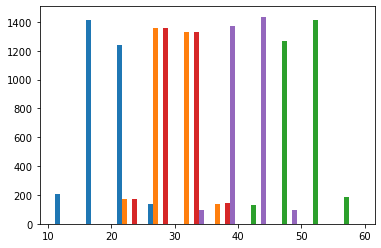

In [87]:
import matplotlib.pyplot as plt
plt.hist(testing_dataset)

In [ ]:
# ignore bellow

In [289]:
class VAE2(nn.Module):
    def __init__(self, zdim, input_dim):
        super(VAE2, self).__init__()

        self.fc1 = nn.Linear(input_dim, 10)
        self.fc2 = nn.Linear(10, 20)
        self.fc21 = nn.Linear(20, zdim)
        self.fc22 = nn.Linear(20, zdim)
        self.fc3 = nn.Linear(zdim, 20)
        self.fc33 = nn.Linear(20, 10)
        self.fc4 = nn.Linear(10, input_dim)
        self.input_dim = input_dim
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h33 = F.relu(self.fc33(h3))
        return self.fc4(h33)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [291]:
batch_size = 128

model = VAE2(5, 5)
train(model, num_epochs = 300, batch_size = batch_size, learning_rate = 0.02)

Epoch:1, Loss:6475.9424
Epoch:2, Loss:4034.6523
Epoch:3, Loss:4198.7305
Epoch:4, Loss:3335.9277
Epoch:5, Loss:3166.3613
Epoch:6, Loss:2965.6108
Epoch:7, Loss:3052.2549
Epoch:8, Loss:2787.8032
Epoch:9, Loss:2634.5029
Epoch:10, Loss:2477.3872
Epoch:11, Loss:2357.6279
Epoch:12, Loss:2377.3967
Epoch:13, Loss:2166.7646
Epoch:14, Loss:2677.2524
Epoch:15, Loss:2381.0981
Epoch:16, Loss:2202.6194
Epoch:17, Loss:2569.6821
Epoch:18, Loss:2248.9824
Epoch:19, Loss:2159.5342
Epoch:20, Loss:1913.4604
Epoch:21, Loss:1871.1384
Epoch:22, Loss:1661.7332
Epoch:23, Loss:1647.2076
Epoch:24, Loss:1612.2734
Epoch:25, Loss:1619.5652
Epoch:26, Loss:1604.1428
Epoch:27, Loss:1678.8647
Epoch:28, Loss:1622.0874
Epoch:29, Loss:1609.6755
Epoch:30, Loss:1484.8813
Epoch:31, Loss:1610.1050
Epoch:32, Loss:1528.5327
Epoch:33, Loss:1585.6831
Epoch:34, Loss:1489.4523
Epoch:35, Loss:1467.8265
Epoch:36, Loss:1460.7313
Epoch:37, Loss:1316.8362
Epoch:38, Loss:1375.2050
Epoch:39, Loss:1426.3398
Epoch:40, Loss:1362.2239
Epoch:41,